# Neural Style Transfer (2)
Xun Huang et. al, "Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization," ICCV 2017


## Import Libraries
필요한 라이브러리들을 가져옵니다.

In [1]:
%pylab inline

# Mount Google drive
#from google.colab import drive
#drive.mount('/content/drive')

import numpy as np
import gc
#import visdom
import os
import time
import numpy as np
from os import listdir
from PIL import Image
from datetime import datetime
#import ipdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import utils, transforms, models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

Populating the interactive namespace from numpy and matplotlib


## Custom dataset
PyTorch에서 custom dataset을 만들기 위해서는 다음의 3가지가 꼭 있어야합니다.
1. `__init__`
    - 데이터셋을 불러올때 필요한 변수들을 초기화하고 저장하는 역할
    - ex) 데이터셋의 위치 정보, 데이터셋에 존재하는 모든 파일 이름, Image 형식에서 Tensor 형식으로 변환 방법 등
2. `__len__`
    - 데이터셋의 총 길이를 반화하는 함수
    - return과 함께 데이터셋에 존재하는 모든 데이터의 수를 반환하여야합니다.
3. `__getitem__`
    - 데이터셋에서 직접적으로 데이터를 가져오는 함수
    - return과 함께 전처리가 완료된 데이터를 반환하여야합니다.
    - return한 데이터는 데이터 타임이 Tensor인 것을 권장하고 모든 데이터에 대해 shape이 같아야합니다.

In [12]:
class DataManager(Dataset):
    def __init__(self, path_content, path_style, random_crop=True):
        self.path_content = path_content
        self.path_style = path_style
        
        resolution = (256, 256)
        resolution = (128, 128)
        # Preprocessing for imagenet pre-trained network
        if random_crop:
            self.transform = transforms.Compose(
                [
                    transforms.RandomCrop(resolution),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                ]
            )
        else:
            self.transform = transforms.Compose(
                [
                    transforms.CenterCrop(resolution),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                ]
            )

        # Convert pre-processed images to original images
        self.restore = transforms.Compose(
            [
                transforms.Normalize(mean=[-2.118, -2.036, -1.804],
                                     std=[4.367, 4.464, 4.444]),
            ]
        )

        self.list_content = listdir(self.path_content)
        self.list_style = listdir(self.path_style)

        self.num_content = len(self.list_content)
        self.num_style = len(self.list_style)

        assert self.num_content > 0
        assert self.num_style > 0

        self.num = min(self.num_content, self.num_style)

        print('Content root : %s' % (self.path_content))
        print('Style root : %s' % (self.path_style))
        print('Number of content images : %d' % (self.num_content))
        print('Number of style images : %d' % (self.num_style))
        print('Dataset size : %d' % (self.num))

    def __len__(self):
        return self.num

    def __getitem__(self, idx):
        path_to_con = self.path_content + '/' + self.list_content[idx]
        path_to_sty = self.path_style + '/' + self.list_style[idx]

        img_con = Image.open(path_to_con)
        img_con = self.transform(img_con)

        img_sty = Image.open(path_to_sty)
        img_sty = self.transform(img_sty)

        sample = {'content': img_con, 'style': img_sty}

        return sample


## Define model

Encoder와 Decoder의 모델을 정의해줍니다. 

In [3]:
decoder = nn.Sequential(
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 256, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 128, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 128, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 64, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 3, (3, 3))
        )


### AdaIN Layer & Loss function
다음의 함수들을 작성하여 보세요.
1. `AdaINLayer`
    - `AdaINLayer`는 `calc_mean_std` 함수를 이용해 $x$와 $y$의 평균과 표준편차를 얻습니다.
    - `AdaINLayer`는 다음의 식과 같이 구현할 수 있습니다.
$$\text{AdaIN}(x,y)=\sigma(y)\big(\frac{x-\mu(x)}{\sigma(x)}\big)+\mu(y)$$

2. `calc_mean_std`
    - `calc_mean_std`는 $x$와 $y$의 평균과 표준편차를 계산합니다.

3. `calc_loss`
    - `calc_loss`는 content loss 또는 style loss에 따라 다른 방법으로 계산합니다.
    - Content loss의 계산 방법은 다음과 같습니다.
    $$\mathcal{L}_{con}(x,y)=MSE(x,y)$$
    - Style loss의 계산 방법은 다음과 같습니다.
    $$\mathcal{L}_{con}(x,y)=MSE(\mu(x)-\mu(y))+MSE(\sigma(x)-\sigma(y))$$

In [4]:
class StyleTransferNet(nn.Module):
    def __init__(self, w_style=0.1, alpha=1):
        super(StyleTransferNet, self).__init__()

        self.w_style = w_style
        self.alpha = alpha
        encoder = list(models.vgg19(pretrained=True).features.children())
        self.enc_1 = nn.Sequential(*encoder[:2])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*encoder[2:7])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*encoder[7:12])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*encoder[12:21])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        for param in self.enc_1.parameters():
            param.requires_grad = False
        for param in self.enc_2.parameters():
            param.requires_grad = False
        for param in self.enc_3.parameters():
            param.requires_grad = False
        for param in self.enc_4.parameters():
            param.requires_grad = False


    def AdaINLayer(self, x, y):
        Bx, Cx, Hx, Wx = x.shape
        By, Cy, Hy, Wy = y.shape

        assert Bx == By
        assert Cx == Cy
        
        ### Your code here ###
        
        
        style_mu, style_sigma = self.calc_mean_std(y)
        content_mu, content_sigma = self.calc_mean_std(x)
        
        normalized_feat = (x - content_mu) / content_sigma
        output = normalized_feat * style_sigma + style_mu
        
        
        ######################
        return output

    def encode_with_intermediate(self, x):
        results = [x]
        h = self.enc_1(x)
        results.append(h)
        h = self.enc_2(h)
        results.append(h)
        h = self.enc_3(h)
        results.append(h)
        h = self.enc_4(h)
        results.append(h)
        return results[1:]

    def encode(self, x):
        h = self.enc_1(x)
        h = self.enc_2(h)
        h = self.enc_3(h)
        h = self.enc_4(h)
        return h

    def calc_mean_std(self, feat, eps=1e-5):
        # eps is a small value added to the variance to avoid divide-by-zero.
        size = feat.size()
        assert (len(size) == 4)
        N, C = size[:2]
        
        
        ### Your code here ###
                
        feat_mean = torch.mean(feat, [2,3], keepdim=True)
        feat_std = torch.std(feat, [2,3], keepdim=True) + eps
        #feat_var = feat.view(N, C, -1).var(dim=2) + eps
        #feat_std = feat_var.sqrt().view(N, C, 1, 1)
        #feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
        
        ######################
        return feat_mean, feat_std

    def calc_loss(self, x, y, loss_type):
        assert (x.size() == y.size())
        assert (y.requires_grad is False)
        assert loss_type=='content' or loss_type=='style'
        if loss_type=='content':
            ### Your code here ###
            
            
            out = self.mse_loss(x, y)
                    
            
            ######################
            return out
        else:
            ### Your code here ###
            
            
            input_mean, input_std = self.calc_mean_std(x)
            target_mean, target_std = self.calc_mean_std(y)
            out = self.mse_loss(input_mean, target_mean) + \
                     self.mse_loss(input_std, target_std)
            
            
            ######################
            return out
        
    def infer_alpha(self, t, content_feat):
        img_result = []
        alpha = 0.
        a = alpha * t + (1 - alpha) * content_feat
        img_result.append(self.decoder(a))
        alpha = 0.25
        a = alpha * t + (1 - alpha) * content_feat
        img_result.append(self.decoder(a))
        alpha = 0.5
        a = alpha * t + (1 - alpha) * content_feat
        img_result.append(self.decoder(a))
        alpha = 0.75
        a = alpha * t + (1 - alpha) * content_feat
        img_result.append(self.decoder(a))
        alpha = 1.
        a = alpha * t + (1 - alpha) * content_feat
        img_result.append(self.decoder(a))

        return img_result

    def forward(self, x, y):
        B, C, H, W = x.shape

        style_feats = self.encode_with_intermediate(y)
        content_feat = self.encode(x)
        t = self.AdaINLayer(content_feat, style_feats[-1])
        if not self.training:
            return self.infer_alpha(t, content_feat)

        img_result = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(img_result)

        loss_c = self.calc_loss(g_t_feats[-1], t, 'content')
        loss_s = self.calc_loss(g_t_feats[0], style_feats[0], 'style')
        for i in range(1, 4):
            loss_s += self.calc_loss(g_t_feats[i], style_feats[i], 'style')

        loss = loss_c + self.w_style*loss_s

        return loss, img_result

## Parameters
optimizer와 weights 부분을 바꾸면서 최적의 학습 파라미터를 찾아보세요.

만약 CUDA_MEMORY_ERROR와 같은 에러가 발생한다면 dataloader에 있는 `batch_size`를 줄여보세요.

In [5]:
### Your parameters here ###
# path
path_snapshot = 'snapshots'
path_content = '/content/drive/MyDrive/Classroom/StyleTransfer/dataset/train/content'
path_style = '/content/drive/MyDrive/Classroom/StyleTransfer/dataset/train/style'

path_content = 'dataset/train/content'
path_style = 'dataset/train/style'

path_content = '../datasets/dataset/train/content'
path_style = '../datasets/dataset/train/style'

# dataloader
batch_size = 16
num_epoch = 30
num_workers = 16

# optimizer
lr_init = 0.0001#0.001
lr_decay_step = num_epoch/2
momentum = 0.9
weight_decay = 1.0e-5

# weights
w_style = 10
alpha = 1

# log steps
log_disp_step = 100
img_disp_step = 10
net_save_step = 10

#############################

## Training

Content root : ../datasets/dataset/train/content
Style root : ../datasets/dataset/train/style
Number of content images : 3000
Number of style images : 3000
Dataset size : 3000


/home/kmbae/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[2021-09-28 11:47:03.898] Epoch   1 /  50, Batch   100 /   188, Loss =  99.26882172
[2021-09-28 11:47:18.070] Epoch   1 /  50, Avg Loss = 120.31937408
[2021-09-28 11:47:34.388] Epoch   2 /  50, Batch   100 /   188, Loss =  58.37994766
[2021-09-28 11:47:48.797] Epoch   2 /  50, Avg Loss =  68.64473724
[2021-09-28 11:48:04.623] Epoch   3 /  50, Batch   100 /   188, Loss =  79.44558716
[2021-09-28 11:48:20.030] Epoch   3 /  50, Avg Loss =  61.10925293
[2021-09-28 11:48:37.166] Epoch   4 /  50, Batch   100 /   188, Loss =  57.54231262
[2021-09-28 11:48:51.870] Epoch   4 /  50, Avg Loss =  57.79236984
[2021-09-28 11:49:08.788] Epoch   5 /  50, Batch   100 /   188, Loss =  93.13837433
[2021-09-28 11:49:23.698] Epoch   5 /  50, Avg Loss =  53.93716049
[2021-09-28 11:49:40.201] Epoch   6 /  50, Batch   100 /   188, Loss =  42.62170410
[2021-09-28 11:49:54.835] Epoch   6 /  50, Avg Loss =  51.98418808
[2021-09-28 11:50:11.136] Epoch   7 /  50, Batch   100 /   188, Loss =  41.49348450
[2021-09-2

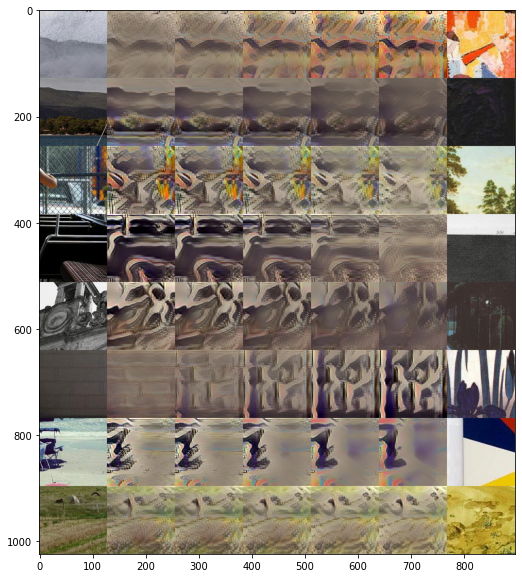

[2021-09-28 11:52:18.132] Epoch  11 /  50, Batch   100 /   188, Loss =  35.81248856
[2021-09-28 11:52:32.756] Epoch  11 /  50, Avg Loss =  44.98456955
[2021-09-28 11:52:49.255] Epoch  12 /  50, Batch   100 /   188, Loss =  41.19762802
[2021-09-28 11:53:04.455] Epoch  12 /  50, Avg Loss =  43.95082092
[2021-09-28 11:53:21.366] Epoch  13 /  50, Batch   100 /   188, Loss =  47.38534546
[2021-09-28 11:53:36.213] Epoch  13 /  50, Avg Loss =  43.53093338
[2021-09-28 11:53:53.051] Epoch  14 /  50, Batch   100 /   188, Loss =  33.13426208
[2021-09-28 11:54:07.181] Epoch  14 /  50, Avg Loss =  43.12427521
[2021-09-28 11:54:24.528] Epoch  15 /  50, Batch   100 /   188, Loss =  41.01718140
[2021-09-28 11:54:38.830] Epoch  15 /  50, Avg Loss =  42.41151810
[2021-09-28 11:54:56.342] Epoch  16 /  50, Batch   100 /   188, Loss =  35.98678970
[2021-09-28 11:55:10.853] Epoch  16 /  50, Avg Loss =  42.00384903
[2021-09-28 11:55:27.384] Epoch  17 /  50, Batch   100 /   188, Loss =  42.39608765
[2021-09-2

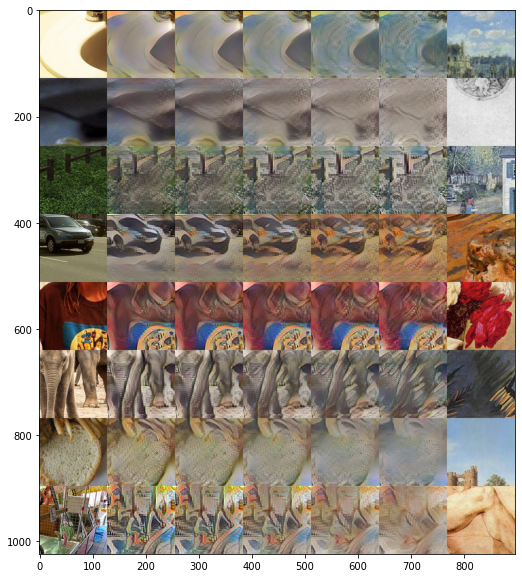

[2021-09-28 11:57:33.711] Epoch  21 /  50, Batch   100 /   188, Loss =  40.73038483
[2021-09-28 11:57:48.649] Epoch  21 /  50, Avg Loss =  39.20863724
[2021-09-28 11:58:05.572] Epoch  22 /  50, Batch   100 /   188, Loss =  38.89173508
[2021-09-28 11:58:19.885] Epoch  22 /  50, Avg Loss =  39.07593918
[2021-09-28 11:58:36.332] Epoch  23 /  50, Batch   100 /   188, Loss =  35.79127502
[2021-09-28 11:58:51.318] Epoch  23 /  50, Avg Loss =  38.70190811
[2021-09-28 11:59:08.094] Epoch  24 /  50, Batch   100 /   188, Loss =  40.80963135
[2021-09-28 11:59:22.835] Epoch  24 /  50, Avg Loss =  37.85270691
[2021-09-28 11:59:39.409] Epoch  25 /  50, Batch   100 /   188, Loss =  35.10411072
[2021-09-28 11:59:54.228] Epoch  25 /  50, Avg Loss =  37.63465118
[2021-09-28 12:00:09.736] Epoch  26 /  50, Batch   100 /   188, Loss =  37.58130646
[2021-09-28 12:00:25.435] Epoch  26 /  50, Avg Loss =  37.61707306
[2021-09-28 12:00:42.229] Epoch  27 /  50, Batch   100 /   188, Loss =  52.34422302
[2021-09-2

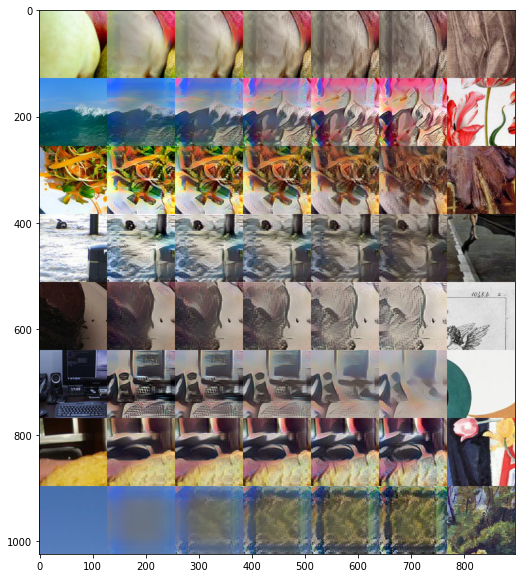

[2021-09-28 12:02:48.329] Epoch  31 /  50, Batch   100 /   188, Loss =  30.07493973
[2021-09-28 12:03:03.160] Epoch  31 /  50, Avg Loss =  36.10442352
[2021-09-28 12:03:19.672] Epoch  32 /  50, Batch   100 /   188, Loss =  35.09901428
[2021-09-28 12:03:34.852] Epoch  32 /  50, Avg Loss =  35.61800766
[2021-09-28 12:03:51.588] Epoch  33 /  50, Batch   100 /   188, Loss =  29.51073456
[2021-09-28 12:04:05.810] Epoch  33 /  50, Avg Loss =  35.69857788
[2021-09-28 12:04:22.603] Epoch  34 /  50, Batch   100 /   188, Loss =  30.41547394
[2021-09-28 12:04:37.845] Epoch  34 /  50, Avg Loss =  35.69861603
[2021-09-28 12:04:55.037] Epoch  35 /  50, Batch   100 /   188, Loss =  68.72001648
[2021-09-28 12:05:09.858] Epoch  35 /  50, Avg Loss =  35.53254318
[2021-09-28 12:05:30.253] Epoch  36 /  50, Batch   100 /   188, Loss =  23.33591843
[2021-09-28 12:05:53.389] Epoch  36 /  50, Avg Loss =  35.22859573
[2021-09-28 12:06:19.793] Epoch  37 /  50, Batch   100 /   188, Loss =  43.83499146
[2021-09-2

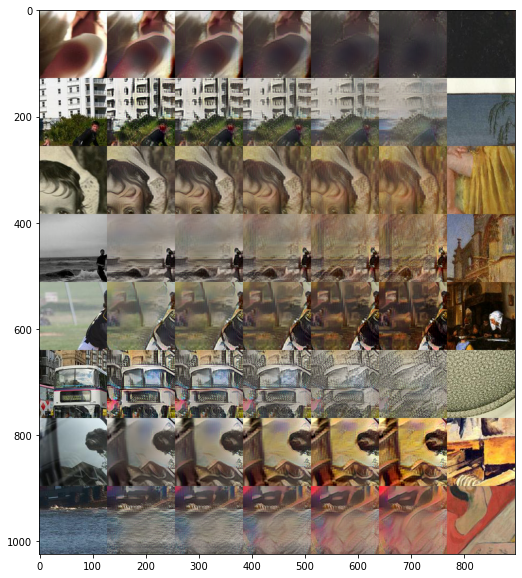

[2021-09-28 12:09:09.709] Epoch  41 /  50, Batch   100 /   188, Loss =  34.10053253
[2021-09-28 12:09:30.113] Epoch  41 /  50, Avg Loss =  34.72697449
[2021-09-28 12:09:46.988] Epoch  42 /  50, Batch   100 /   188, Loss =  39.25994110
[2021-09-28 12:10:01.472] Epoch  42 /  50, Avg Loss =  34.49111557
[2021-09-28 12:10:17.419] Epoch  43 /  50, Batch   100 /   188, Loss =  28.23260880
[2021-09-28 12:10:33.115] Epoch  43 /  50, Avg Loss =  34.72482300
[2021-09-28 12:10:49.935] Epoch  44 /  50, Batch   100 /   188, Loss =  35.24487686
[2021-09-28 12:11:04.802] Epoch  44 /  50, Avg Loss =  34.37442398
[2021-09-28 12:11:21.512] Epoch  45 /  50, Batch   100 /   188, Loss =  36.29340363
[2021-09-28 12:11:36.239] Epoch  45 /  50, Avg Loss =  33.67614365
[2021-09-28 12:11:52.495] Epoch  46 /  50, Batch   100 /   188, Loss =  26.65342903
[2021-09-28 12:12:07.395] Epoch  46 /  50, Avg Loss =  33.47005463
[2021-09-28 12:12:23.732] Epoch  47 /  50, Batch   100 /   188, Loss =  46.63832092
[2021-09-2

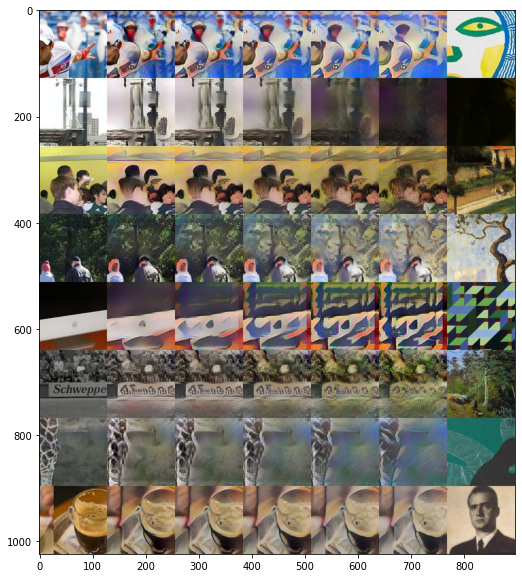

Training finished.


In [6]:
if not os.path.exists(path_snapshot):
    os.makedirs(path_snapshot)
    
# Data loader
dm = DataManager(path_content, path_style, random_crop=True)
dl = DataLoader(dm, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=False)

num_train = dm.num
num_batch = np.ceil(num_train / batch_size)
loss_train_avg = np.zeros(num_epoch)

net = StyleTransferNet(w_style, alpha)

# Define your optimizer in here to train only the decoder network
optimizer = torch.optim.Adam(net.decoder.parameters(), lr=lr_init)

# Multi-GPU if available
net = nn.DataParallel(net.cuda(), device_ids=range(torch.cuda.device_count()))

# Start training
for epoch in range(0, num_epoch):
    net.train()
    running_loss_train = 0
    np.random.shuffle(dl.dataset.list_style)

    for i, data in enumerate(dl, 0):
        img_con = data['content'].cuda()
        img_sty = data['style'].cuda()

        optimizer.zero_grad()

        loss, img_result = net(img_con, img_sty)

        loss = torch.mean(loss)
        loss.backward()

        optimizer.step()

        running_loss_train += loss

        if (i+1)%log_disp_step==0:
            print('[%s] Epoch %3d / %3d, Batch %5d / %5d, Loss = %12.8f' %
              (str(datetime.now())[:-3], epoch + 1, num_epoch,
               i + 1, num_batch, loss))

    loss_train_avg[epoch] = running_loss_train / num_batch

    print('[%s] Epoch %3d / %3d, Avg Loss = %12.8f' % \
          (str(datetime.now())[:-3], epoch + 1, num_epoch,
           loss_train_avg[epoch]))

    if (epoch + 1)%img_disp_step == 0:
        with torch.no_grad():
            net.eval()
            img_result = net(img_con, img_sty)
            img_result.insert(0, img_con)
            img_result.append(img_sty)
            img_cat = torch.cat(img_result, dim=3)
            img_cat = torch.unbind(img_cat, dim=0)
            img_cat = torch.cat(img_cat, dim=1)
            img_cat = dm.restore(img_cat.data.cpu())
            output_img = torch.clamp(img_cat, 0, 1)
            
        tt = transforms.ToPILImage()(output_img)
        gcf().set_size_inches(10,10)
        imshow(tt)
        show()

    # Snapshot
    if ((epoch + 1) % net_save_step) == 0:
        torch.save(net.module.state_dict(), '%s/epoch_%06d.pth' % (path_snapshot, epoch + 1))

#torch.save(net.state_dict(), '%s/epoch_%06d.pth' % (path_snapshot, epoch + 1))
print('Training finished.')

## Testing

테스트를 수행하기 위한 코드로 테스트 데이터셋에 대한 결과가 colab에 저장됩니다.

`model_path`에 학습한 checkpoint 파일의 경로를 입력하여 학습한 모델을 테스트해보세요.

주의!!!) checkpoint 파일과 테스트 결과는 colab를 초기화 할 경우 모두 사라집니다. 꼭 본인의 pc로 백업을 받아 두세요.

Content root : dataset/test/content
Style root : dataset/test/style
Number of content images : 10
Number of style images : 10
Dataset size : 10


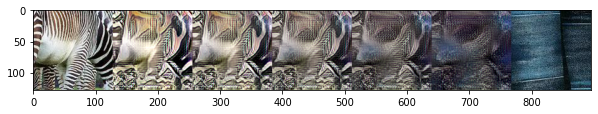

Testing 1/10 images


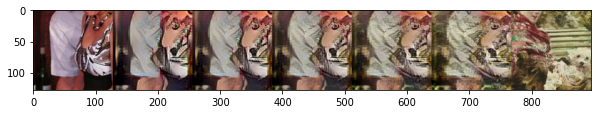

Testing 2/10 images


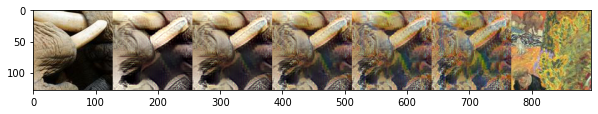

Testing 3/10 images


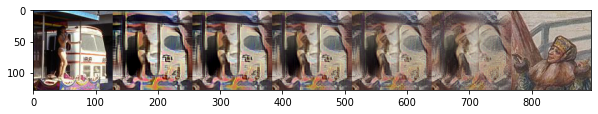

Testing 4/10 images


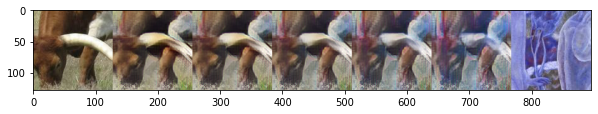

Testing 5/10 images


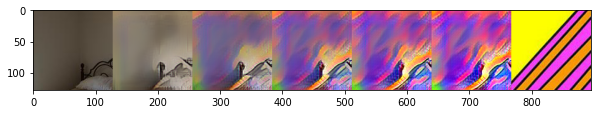

Testing 6/10 images


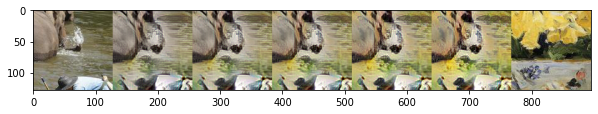

Testing 7/10 images


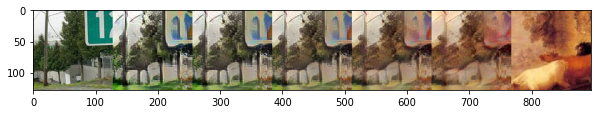

Testing 8/10 images


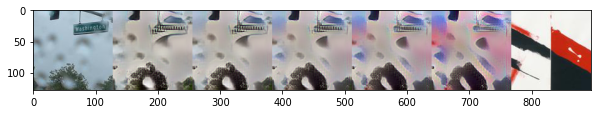

Testing 9/10 images


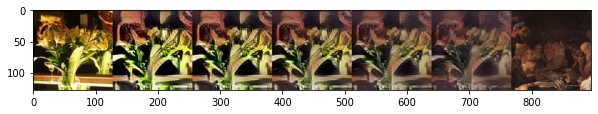

Testing 10/10 images
Testing finished.


In [13]:
### Parameters ###
path_content = '/content/drive/MyDrive/Classroom/StyleTransfer/dataset/test/content'
path_style = '/content/drive/MyDrive/Classroom/StyleTransfer/dataset/test/style'

path_content = 'dataset/test/content'
path_style = 'dataset/test/style'

### Your parameters here ###
model_path = 'snapshots/epoch_000030.pth'

############################

batch_size = 1
w_style = 10
alpha = 1
disp_step = 1

# Data loader
dm = DataManager(path_content, path_style, random_crop=False)
dl = DataLoader(dm, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)


net = StyleTransferNet(w_style, alpha)
net = nn.DataParallel(net.cuda(), device_ids=range(torch.cuda.device_count()))

# Load model
state_dict = torch.load(model_path)
net.module.load_state_dict(state_dict)

# Start testing
net.eval()

with torch.no_grad():
    for i, data in enumerate(dl, 0):
        img_con = data['content'].cuda()
        img_sty = data['style'].cuda()

        img_result = net(img_con, img_sty)
        img_result.insert(0, img_con)
        img_result.append(img_sty)
        img_cat = torch.cat(img_result, dim=3)
        img_cat = torch.unbind(img_cat, dim=0)
        img_cat = torch.cat(img_cat, dim=1)
        img_cat = dm.restore(img_cat.data.cpu())
        output_img = torch.clamp(img_cat, 0, 1)

        tt=transforms.ToPILImage()(output_img)
        #tt.save('test_out/{}.png'.format(i))
        gcf().set_size_inches(10,10)
        imshow(tt)
        show()
        
        if (i+1)%disp_step==0:
            print('Testing {}/{} images'.format(i + 1, len(dl)))


gc_collected = gc.collect()
gc.disable()

print('Testing finished.')